In [1]:
import logging
logging.getLogger("kamene.runtime").setLevel(logging.ERROR)
from kamene.all import *
from pynq_networking import *
from math import log2 

A = 0.1 # Smoothing factor
WINDOW_SIZE = 30 # in seconds
OVERLAP = 0.8
INTERVAL_SEC = WINDOW_SIZE - WINDOW_SIZE*OVERLAP
PARAMS = ["src", "sport", "dport"]
FILTER = "dst 192.168.1.6 and (tcp or udp)"

# Observed entropies
H = []
H_archive = [[] for i in range(len(PARAMS))]

# Predicted entropies
H_predict = []

# Parameters entropy prediction error
err = []

d = 0 # Anomaly score
d_archive = []

timeline = []

In [2]:
overlap_flows = [[] for i in range(int(OVERLAP/(1-OVERLAP)))]
overlap_flows_count = [[] for i in range(int(OVERLAP/(1-OVERLAP)))]
overlap_flows_pkts = [0 for i in range(int(OVERLAP/(1-OVERLAP)))]
current_flows = []
current_flows_count = []
current_flows_pkts = 0
def shift_flows():
    for i in range(len(overlap_flows)-1):
        overlap_flows[i] = overlap_flows[i+1]
        overlap_flows_count[i] = overlap_flows_count[i+1]
        overlap_flows_pkts[i] = overlap_flows_pkts[i+1]
    overlap_flows[len(overlap_flows)-1] = current_flows
    overlap_flows[len(overlap_flows)-1] = current_flows_count
    overlap_flows_pkts[len(overlap_flows)-1] = current_flows_pkts

In [3]:
def packet_processing(packet):
    global current_flows_pkts
    current_flows_pkts = current_flows_pkts + 1
    flow = {}
    if(IP in packet):
        print('src: ',  packet[IP].src, '; sport: ', packet[IP].sport, '; dport: ', packet[IP].dport)
        flow = {'src': packet[IP].src, 'sport': packet[IP].sport, 'dport': packet[IP].dport}            
    if(flow != {} and (flow not in current_flows)):
        current_flows.append(flow)
        current_flows_count.append(1)
    else:
        i = current_flows.index(flow)
        current_flows_count[i] = current_flows_count[i] + 1

In [4]:
def calc_entropy(param):
    values = []
    freqs = []
    for i in len(overlap_flows):
        for j in len(overlap_flows[i]):
            if(overlap_flows[i][j][param] not in values):
                values.append(overlap_flows[i][j][param])
                freqs.append(1)
            else:
                index = values.index(overlap_flows[i][j][param])
                freqs[index] = freq[index] + overlap_flows_count[i][j]
    entropy = 0
    for i in range(len(freq)):
        p = freqs[i][param] / current_packets
        entropy = entropy - p*log2(p)
    entropy = entropy / log2(current_packets) # Normalize entropy
    return entropy
    
def predict_entropy(param):
    return H_predict[PARAMS.index(param)]*(1-A) + H[PARAMS.index(param)]*A
    
def calc_error(params):
    return abs(H_predict[PARAMS.index(param)]-H[PARAMS.index(param)])

In [5]:
# Preparation stage
for i in range(len(overlap_flows)):
    pkt_trace = sniff(iface="br0",
                      timeout = INTERVAL_SEC, filter=FILTER,
                      prn=lambda x: packet_processing(x))
    shift_flows()
    
pkt_trace = sniff(iface="br0",
                  timeout = INTERVAL_SEC, filter=FILTER,
                  prn=lambda x: packet_processing(x))
H = map(calc_entropy, PARAMS)
H_predict = map(predict_entropy, PARAMS)

src:  240.143.79.36 ; sport:  21350 ; dport:  51522
src:  240.143.79.36 ; sport:  21350 ; dport:  51522
src:  240.143.79.36 ; sport:  21350 ; dport:  51522
src:  240.143.79.36 ; sport:  21350 ; dport:  51522
src:  240.143.79.36 ; sport:  21350 ; dport:  51522
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  22.7.198.68 ; sport:  20964 ; dport:  15757
src:  22.7.198.68 ; sport:  20964 ; dport:  15757
src:  22.7.198.68 ; sport:  20964 ; dport:  15757
src:  22.7.198.68 ; sport:  20964 ; dport:  15757
src:  22.7.198.68 ; sport:  20964 ; dport:  15757
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  192.168.1.15 ; sport:  22604 ; dport:  9090
src:  226.15.5.158 ; sport:  25461 ; dport:  40975
src:  226.15.5.158 ; sport:  25461 ; dp

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def draw_graphs():
    while(True):
        fig, ax = plt.subplots()
        for i in range(len(PARAMS)):
            ax.plot(timeline, H_archive[i], label=PARAMS[i]);
        ax.plot(timeline, d_archive, label="Anomaly score")
        plt.pause(INTERVAL_SEC)

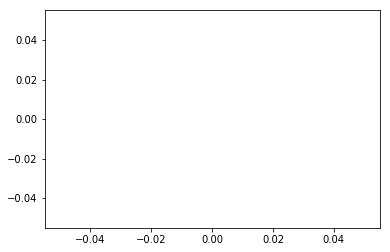

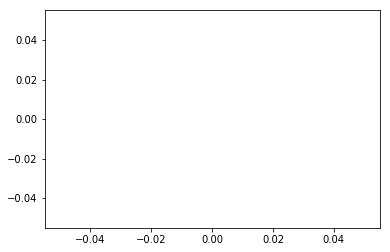

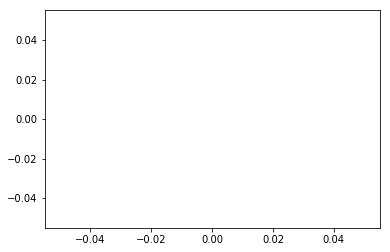

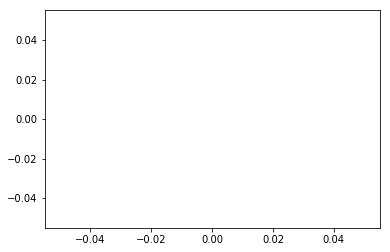

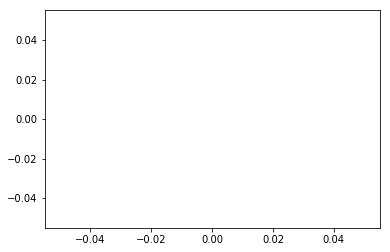

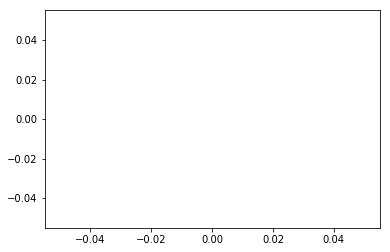

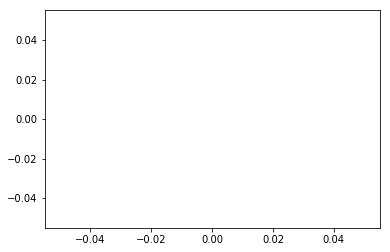

KeyboardInterrupt: 

In [7]:
import datetime

draw_graphs()
while(True):
    pkt_trace = sniff(iface="br0",
                      timeout = INTERVAL_SEC, filter=FILTER,
                      prn=lambda x: packet_processing(x))
    
    timeline.append(datetime.datetime.now())
    for i in range(len(PARAMS)):
        H_archive[i].append(H[i])
    d_archive.append(d)
    
    H = map(calc_entropy, PARAMS)
    err = map(calc_error, PARAMS)
    d = sum(err)
    H_predict = map(PARAMS, predict_entropy)